In [1]:
from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
GaussianMix = GaussianMixture.symmetric_2D(4,std = 1)

rec1 = RectangleDataset(device=device, coords= [(-5.0,5.0),(-10,10)])

dataset = union_sample([GaussianMix, rec1])

gaussian_path = GaussianConditionalProbabilityPath(p_data=dataset, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=6)

trainer = RecCenterGuidanceTrainer(path=gaussian_path, model=model1,  num_conditions=6, p_uncond=0.1,model_type="FM", rectangle_boundaries=[[(-5.0,5.0),(-10,10)]], centers=[torch.Tensor([10.0,0.0]), torch.Tensor([0.0,-10.0]), torch.Tensor([0.0,10.0]), torch.Tensor([-10.0,0.0])])

trainer.train_loop(num_epochs=15000, device=device, lr=1e-3, n= 2000)

In Epoch 0 we have a loss of 37.93323516845703
In Epoch 1000 we have a loss of 6.383388042449951
In Epoch 2000 we have a loss of 9.21699047088623
In Epoch 3000 we have a loss of 10.241724014282227
In Epoch 4000 we have a loss of 6.734550952911377
In Epoch 5000 we have a loss of 6.853431701660156
In Epoch 6000 we have a loss of 5.929936408996582
In Epoch 7000 we have a loss of 7.764921188354492
In Epoch 8000 we have a loss of 6.2916259765625
In Epoch 9000 we have a loss of 6.900761127471924
In Epoch 10000 we have a loss of 7.757286071777344
In Epoch 11000 we have a loss of 6.573462963104248
In Epoch 12000 we have a loss of 156.3168487548828
In Epoch 13000 we have a loss of 10.269747734069824
In Epoch 14000 we have a loss of 7.012266635894775


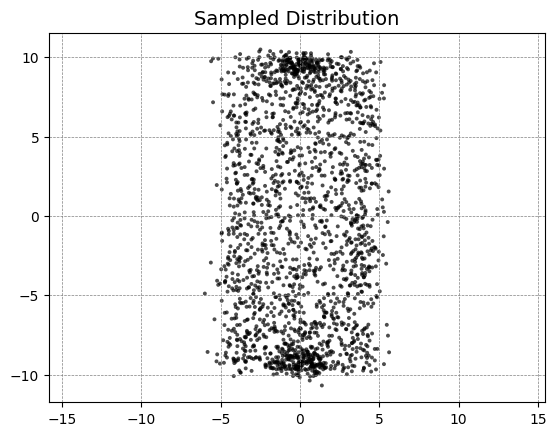

In [4]:
ode = GuidedVectorField(model1, guidance_scale=1, null_index=5)
solver = EulerODESolver(ode)
sampler = Sampler(solver)

steps = torch.linspace(0.01, 1, 2000).view(1, -1, 1).expand(2000, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(2000)

condition_index = 4
y_index = torch.full((gaussian_samples.shape[0],), fill_value=condition_index, dtype=torch.long, device=device)

final_samples = sampler.sample_without_traj(gaussian_samples, steps, y_index = y_index)

plot_samples(final_samples)
plt.show()

Lets look at the diffusion case for guidance

In [5]:
GaussianMix = GaussianMixture.symmetric_2D(4,std = 1)

rec1 = RectangleDataset(device=device, coords= [(-5.0,5.0),(-10,10)])

dataset = union_sample([GaussianMix, rec1])

gaussian_path = GaussianConditionalProbabilityPath(p_data=dataset, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=6)

trainer = RecCenterGuidanceTrainer(path=gaussian_path, model=model1, num_conditions=5, p_uncond=0.1,model_type="Diffusion",rectangle_boundaries=[[(-5.0,5.0),(-10,10)]], centers=[torch.Tensor([10.0,0.0]), torch.Tensor([0.0,-10.0]), torch.Tensor([0.0,10.0]), torch.Tensor([-10.0,0.0])])

trainer.train_loop(num_epochs=10000, device=device, lr=1e-3, n= 2000)

In Epoch 0 we have a loss of 6.571479797363281
In Epoch 1000 we have a loss of 9.845317840576172
In Epoch 2000 we have a loss of 9.68500804901123
In Epoch 3000 we have a loss of 6.41935920715332
In Epoch 4000 we have a loss of 9.902077674865723
In Epoch 5000 we have a loss of 9.754050254821777
In Epoch 6000 we have a loss of 12.570229530334473
In Epoch 7000 we have a loss of 7.073299884796143
In Epoch 8000 we have a loss of 6.611440658569336
In Epoch 9000 we have a loss of 11.848250389099121


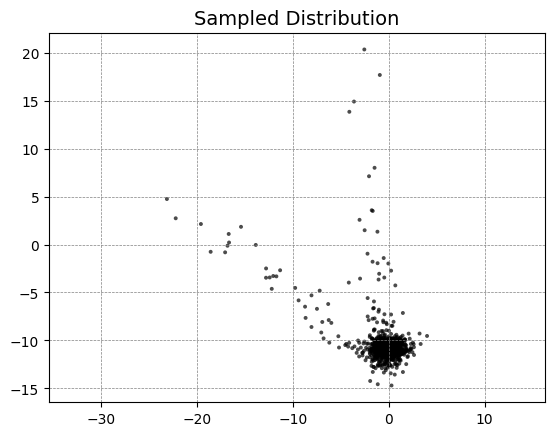

In [33]:
sde = ProductGuidanceLangevin([model1], alpha=LinearAlpha(), beta=SquareRootBeta(), sigma=1.0, guidance_scales=[1.0], null_index=trainer.null_index)
sdesolver = EulerSDESolver(sde)
sdesampler = Sampler(sdesolver)

steps = torch.linspace(0.01, 1, 1000).view(1, -1, 1).expand(1000, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(1000)



condition_index1 = 1
y_index1 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index1, dtype=torch.long, device=device)

condition_index2 = 1
y_index2 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index2, dtype=torch.long, device=device)

indicies = [y_index2]

final_samples = sdesampler.sample_without_traj(gaussian_samples, steps, y_index = indicies)

plot_samples(final_samples)
plt.show()